# Twitter Sentiment Analysis
## Random Forests Sentiment Classification of Airline Tweets 
Holly Figueroa  
DSC 680  
Project 2

**Dataset Source:** https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [139]:
import numpy
import nltk
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [140]:
# Load data and view
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [141]:
df.shape

(14640, 15)

## EDA

In [142]:
# Get null counts for each column
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [143]:
# Class Value Counts
sentiment = pd.DataFrame(df['airline_sentiment'].value_counts())
sentiment

,airline_sentiment
negative,9178
neutral,3099
positive,2363


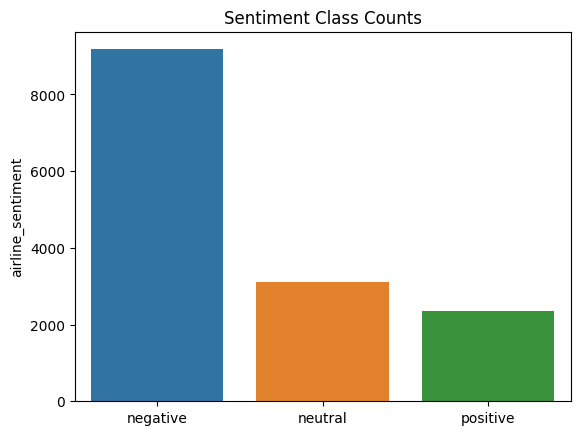

In [144]:
# Create bar plot of sentiment class labels
sns.barplot(sentiment, x = sentiment.index, y = 'airline_sentiment').set_title('Sentiment Class Counts')
plt.show()

In [145]:
# Get value counts for airlines
airlines = pd.DataFrame(df['airline'].value_counts())
airlines

,airline
United,3822
US Airways,2913
American,2759
Southwest,2420
Delta,2222
Virgin America,504


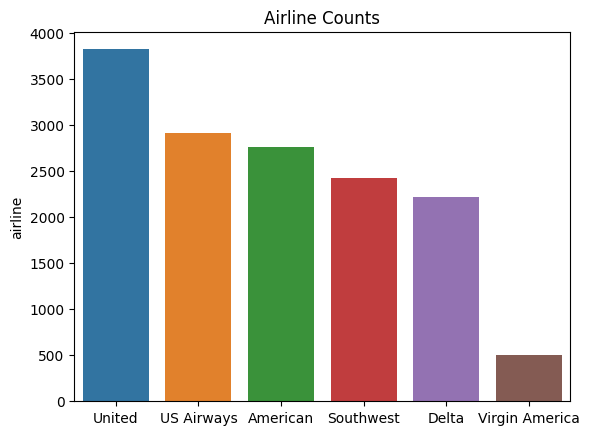

In [146]:
# Create bar plot of airlines represented in dataset
sns.barplot(airlines, x = airlines.index, y = 'airline').set_title('Airline Counts')
plt.show()

In [147]:
# Plot histogram of retweets
df['retweet_count'].value_counts()

0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
28        1
9         1
18        1
11        1
31        1
15        1
44        1
Name: retweet_count, dtype: int64

In [148]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [149]:
# Drop columns
df = df.drop(columns=['negativereason', 'negativereason_confidence',
       'airline_sentiment_gold', 'name', 'negativereason_gold', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], axis = 1)

In [150]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'airline', 'retweet_count', 'text'],
      dtype='object')

In [151]:
# Rename Columns
df.columns = ['tweet_id', 'sentiment', 'confidence',
       'airline', 'retweets', 'text']

In [152]:
df.head()

,tweet_id,sentiment,confidence,airline,retweets,text
0,570306133677760513,neutral,1.0000,Virgin America,0,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,0.3486,Virgin America,0,@VirginAmerica plus you've added commercials to the experience... tacky.
2,570301083672813571,neutral,0.6837,Virgin America,0,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,570301031407624196,negative,1.0000,Virgin America,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,570300817074462722,negative,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing about it


# Preprocessing

In [153]:
# Removing lowercase all texts
df['clean'] = df['text'].str.lower()
df['clean'] = df['clean'].str.strip()

### Remove URLS

In [154]:
# See url tweets
pd.set_option('display.max_colwidth', None)
links = df[df['clean'].str.contains('http')]
print(links['clean'][:5])

7                                     @virginamerica really missed a prime opportunity for men without hats parody, there. https://t.co/mwpg7grezp
13    @virginamerica @virginmedia i'm flying your #fabulous #seductive skies again! u take all the #stress away from travel http://t.co/ahlxhhkiyn
21                                                                                      @virginamerica i love this graphic. http://t.co/ut5grrwaaa
34             @virginamerica this is great news!  america could start flights to hawaii by end of year http://t.co/r8p2zy3fe4 via @pacificbiznews
35    nice rt @virginamerica: vibe with the moodlight from takeoff to touchdown. #moodlitmonday #sciencebehindtheexperience http://t.co/y7o0unxtqp
Name: clean, dtype: object


In [155]:
# Create function to remove urls
def remove_urls(tweet):
    # Regex pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    # Using sub() to remove URLs from the tweet
    return url_pattern.sub('', tweet)

In [156]:
# Use function on clean column of tweets
df['clean'] = df['clean'].apply(remove_urls)

In [157]:
# Check for urls
pd.set_option('display.max_colwidth', None)
links = df[df['clean'].str.contains('http')]
print(links['clean'])

Series([], Name: clean, dtype: object)


### Remove User Handles

In [158]:
# Create function to remove twitter handles
def remove_handles(tweet):
    return re.sub(r'@(\w+)', '', tweet)

In [159]:
# Apply function
df['clean'] = df['clean'].apply(remove_handles)

In [160]:
# Check handles were removed
df[['text','clean']].head()

,text,clean
0,@VirginAmerica What @dhepburn said.,what said.
1,@VirginAmerica plus you've added commercials to the experience... tacky.,plus you've added commercials to the experience... tacky.
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,i didn't today... must mean i need to take another trip!
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,@VirginAmerica and it's a really big bad thing about it,and it's a really big bad thing about it


### Remove Stopwords

In [161]:
# Remove stop words
def remove_stopwords(tweet):
    words = tweet.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    # Join the filtered words back into a string
    return ' '.join(filtered_words)

In [162]:
# Apply the remove_stopwords function to the 'tweets' column
df['clean'] = df['clean'].apply(remove_stopwords)

In [163]:
# Check results
df[['text','clean']].head()

,text,clean
0,@VirginAmerica What @dhepburn said.,said.
1,@VirginAmerica plus you've added commercials to the experience... tacky.,plus added commercials experience... tacky.
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,today... must mean need take another trip!
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","really aggressive blast obnoxious ""entertainment"" guests' faces &amp; little recourse"
4,@VirginAmerica and it's a really big bad thing about it,really big bad thing


### Remove Special Characters

In [164]:
# Create function to remove special characters, quotes, and keep (!?)
def clean_characters(tweet):
    # Remove special characters (except exclamation marks and question marks), single quotes, and double quotes
    clean_chars = re.sub(r'[^\w\s!?]', '', tweet)
    return clean_chars

In [165]:
# Apply function
df['clean'] = df['clean'].apply(clean_characters)

In [166]:
# Check results
df[['text','clean']].head()

,text,clean
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,plus added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,today must mean need take another trip!
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",really aggressive blast obnoxious entertainment guests faces amp little recourse
4,@VirginAmerica and it's a really big bad thing about it,really big bad thing


### Visualize Tweet Lengths Before and After Cleaning

In [167]:
df.columns

Index(['tweet_id', 'sentiment', 'confidence', 'airline', 'retweets', 'text',
       'clean'],
      dtype='object')

In [168]:
# Gets tweet lengths and sentiment to plot
cln_len = df.loc[:,['clean','sentiment']]
raw_len = df.loc[:,['text','sentiment']]

# Add new column including length of tweet
cln_len['length'] = cln_len['clean'].apply(len)
raw_len['length'] = raw_len['text'].apply(len)

cln_len.head()

,clean,sentiment,length
0,said,neutral,4
1,plus added commercials experience tacky,positive,39
2,today must mean need take another trip!,neutral,39
3,really aggressive blast obnoxious entertainment guests faces amp little recourse,negative,80
4,really big bad thing,negative,20


In [169]:
raw_len.head()

,text,sentiment,length
0,@VirginAmerica What @dhepburn said.,neutral,35
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,72
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,71
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,126
4,@VirginAmerica and it's a really big bad thing about it,negative,55


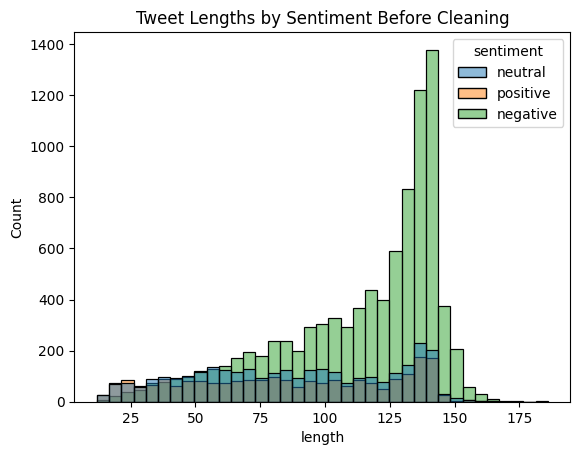

In [170]:
# Visualize Tweet Lengths Before Cleaning
fig = sns.histplot(data = raw_len, 
             x='length', 
             hue = 'sentiment')
fig.set_title('Tweet Lengths by Sentiment Before Cleaning')
plt.show()

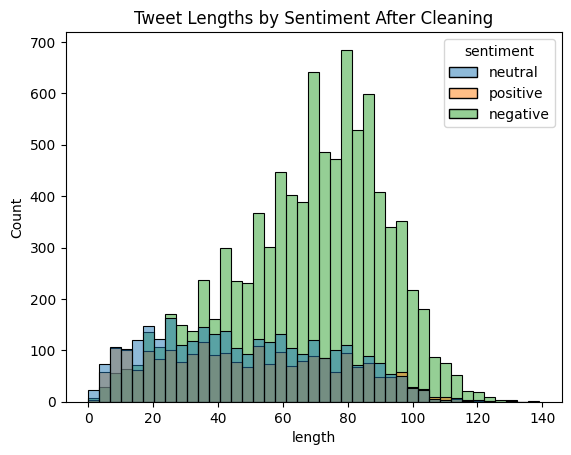

In [171]:
# Visualize Tweet Lengths After Cleaning
fig = sns.histplot(data = cln_len, 
             x='length', 
             hue = 'sentiment')
fig.set_title('Tweet Lengths by Sentiment After Cleaning')
plt.show()

In [172]:
# Get min and max length of cleaned text
cln_len['length'].describe()

count    14640.000000
mean        60.796038
std         26.623136
min          0.000000
25%         40.000000
50%         64.000000
75%         82.000000
max        139.000000
Name: length, dtype: float64

### Drop rows with minimal text content

In [173]:
df[df['clean'].apply(len)<4]

,tweet_id,sentiment,confidence,airline,retweets,text,clean
179,569324558999691264,neutral,0.6701,Virgin America,0,@VirginAmerica @TTINAC11 I DM you,dm
784,570082243596591104,neutral,0.6533,United,0,@united @luke_mcintosh68 nah you wouldn't,nah
1644,569637147067551746,negative,0.6484,United,0,@united now this http://t.co/uygeW2Nosr,
2113,569363796113764352,negative,0.6809,United,0,@united just DM'd,dmd
2607,569004759069421568,negative,1.0000,United,0,@united no u don't,u
3485,568390014238916608,neutral,1.0000,United,0,@united for a fee...,fee
3611,568234670166568960,negative,0.6838,United,0,@united yes I have,yes
4612,569980137346707456,neutral,0.6774,Southwest,0,@SouthwestAir Why do you have to be 18 😭,18
5333,569184833361936387,neutral,0.6843,Southwest,0,@SouthwestAir I DM'd you,dmd
5655,568830255282040832,neutral,1.0000,Southwest,0,@SouthwestAir I will dm you now,dm


In [174]:
# Drop rows with less than 4 characters
df = df[df['clean'].apply(len)>3]

In [175]:
df.shape

(14607, 7)

### Tokenize Tweets

In [176]:
# Tokenize tweets
df['clean'] = df['clean'].apply(nltk.word_tokenize)
df[['text','clean']].head()

,text,clean
0,@VirginAmerica What @dhepburn said.,[said]
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[plus, added, commercials, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[today, must, mean, need, take, another, trip, !]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guests, faces, amp, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"


### Stem Words

In [177]:
from nltk.stem.porter import PorterStemmer

In [178]:
# instantiate porter stemmer
porter = PorterStemmer()

In [179]:
# Apply to words in clean text
df['stemmed'] = df['clean'].apply(lambda x: [porter.stem(word) for word in x])

In [180]:
# recombine
df['stemmed'] = df['stemmed'].str.join(' ')

In [181]:
df['stemmed'].head()

0                                                                  said
1                                          plu ad commerci experi tacki
2                                today must mean need take anoth trip !
3    realli aggress blast obnoxi entertain guest face amp littl recours
4                                                  realli big bad thing
Name: stemmed, dtype: object

### Drop Neutral Class and Label Encode Targets

In [182]:
from sklearn.preprocessing import LabelEncoder

In [183]:
# Drop Neutral Sentiment
df = df[df['sentiment'] != 'neutral']
df['sentiment'].value_counts()

negative    9170
positive    2360
Name: sentiment, dtype: int64

In [194]:
# Encode target labels into new col
le = LabelEncoder()
df['coded_sentiment'] = le.fit_transform(df['sentiment'])
df.head()

,tweet_id,sentiment,confidence,airline,retweets,text,clean,stemmed,coded_sentiment
1,570301130888122368,positive,0.3486,Virgin America,0,@VirginAmerica plus you've added commercials to the experience... tacky.,"[plus, added, commercials, experience, tacky]",plu ad commerci experi tacki,1
3,570301031407624196,negative,1.0000,Virgin America,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guests, faces, amp, little, recourse]",realli aggress blast obnoxi entertain guest face amp littl recours,0
4,570300817074462722,negative,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]",realli big bad thing,0
5,570300767074181121,negative,1.0000,Virgin America,0,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,"[seriously, would, pay, 30, flight, seats, playing, really, bad, thing, flying, va]",serious would pay 30 flight seat play realli bad thing fli va,0
6,570300616901320704,positive,0.6745,Virgin America,0,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)","[yes, nearly, every, time, fly, vx, ear, worm, wont, go, away]",ye nearli everi time fli vx ear worm wont go away,1


### Split for Model Training and Testing

In [195]:
from sklearn.model_selection import train_test_split

In [252]:
# Create training set and test set
X = df['stemmed']
y = df['coded_sentiment']

In [253]:
# Create training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42)

In [254]:
# Compare training and testing shapes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9224,) (9224,) (2306,) (2306,)


### Null Accuracy

In [270]:
# check class distribution in test set
y_test.value_counts()

0    1834
1     472
Name: coded_sentiment, dtype: int64

In [271]:
# check null accuracy score
null_accuracy = 1834/(1834+472)
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.7953


### Vectorize Data

In [255]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

In [256]:
# Store vectorizer into variable
# tfidf = TfidfVectorizer()

# # Create tf_idf feature matrix using apply
# feature_matrix = tfidf.fit_transform(X_train)

# # use transform to apply tfidf vectorization to test data
# test_matrix = tfidf.transform(X_test)

In [257]:
# Store vectorizer into variable
vctrz = CountVectorizer()

# Create tf_idf feature matrix using apply
feature_matrix = vctrz.fit_transform(X_train)

# use transform to apply tfidf vectorization to test data
test_matrix = vctrz.transform(X_test)

## Modeling with Logistic Regression

In [273]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [276]:
# Create logistic regression object
logistic_regression = LogisticRegression()

RFC = RandomForestClassifier(random_state = 0)

GBC = GradientBoostingClassifier()
# Train model with training data
#model = logistic_regression.fit(feature_matrix,y_train)
#model = RFC.fit(feature_matrix,y_train)
model = GBC.fit(feature_matrix,y_train)

### Model Evaluation

In [277]:
# View model score
model.score(feature_matrix, y_train)

0.8882263660017347

In [278]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score

In [279]:
# check accuracy using accuracy_score
# create array of predicted values to pass to accuracy score()
accuracy_score(y_test, model.predict(test_matrix))

0.8924544666088465

In [280]:
# Check accuracy using the mean of cross_val_score
cross_val_score(model, test_matrix, y_test, scoring = 'accuracy').mean()

0.8781493271731883

### Move Results to Confusion Matrix

In [281]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [282]:
# Create confusion matrix
c_matrix = confusion_matrix(y_test, model.predict(test_matrix))

# View matrix
c_matrix

array([[1771,   63],
       [ 185,  287]], dtype=int64)

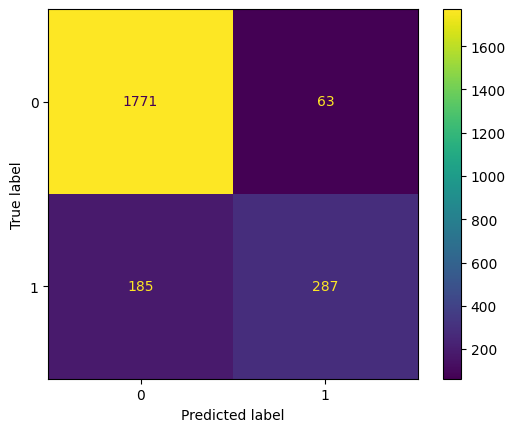

In [283]:
# Use display matrix function to heatmap prediction/true cases

disp = ConfusionMatrixDisplay(c_matrix)
disp.plot()

plt.show()

In [284]:
#predicting output for test data
pred = model.predict(test_matrix)

In [285]:
# Get accuracy/eval metrics for each class
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.93      1834
           1       0.82      0.61      0.70       472

    accuracy                           0.89      2306
   macro avg       0.86      0.79      0.82      2306
weighted avg       0.89      0.89      0.89      2306



In [269]:
# Get accuracy/eval metrics for each class RFC
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1834
           1       0.83      0.69      0.75       472

    accuracy                           0.91      2306
   macro avg       0.88      0.83      0.85      2306
weighted avg       0.90      0.91      0.90      2306

